Date Began: May 20, 2024

The goal here is to do a lot of cleaning and model building that's annoying to do in PowerBI desktop in python. I have a better idea of how I want my semantic model to look and it's easier to just clean this all up here. 

We'll also be doing all of this using `Polars` as I've never used it before!

# Data Loading

In [1]:
import polars as pl

In [2]:
data = pl.read_excel(
    source="../data/powerbi_exports/FireEmblemData05202024.xlsx",
    sheet_id=0 # This loads in all of the sheets at once
)

data

{'Characters': shape: (43, 3)
 ┌──────────┬───────────────────┬─────┐
 │ Name     ┆ Game              ┆ ID  │
 │ ---      ┆ ---               ┆ --- │
 │ str      ┆ str               ┆ i64 │
 ╞══════════╪═══════════════════╪═════╡
 │ Amelia   ┆ the-sacred-stones ┆ 0   │
 │ Artur    ┆ the-sacred-stones ┆ 1   │
 │ Caellach ┆ the-sacred-stones ┆ 2   │
 │ Colm     ┆ the-sacred-stones ┆ 3   │
 │ Cormag   ┆ the-sacred-stones ┆ 4   │
 │ …        ┆ …                 ┆ …   │
 │ Syrene   ┆ the-sacred-stones ┆ 38  │
 │ Tana     ┆ the-sacred-stones ┆ 39  │
 │ Tethys   ┆ the-sacred-stones ┆ 40  │
 │ Valter   ┆ the-sacred-stones ┆ 41  │
 │ Vanessa  ┆ the-sacred-stones ┆ 42  │
 └──────────┴───────────────────┴─────┘,
 'Weapons': shape: (61, 4)
 ┌──────────┬───────────────────┬──────┬────────┐
 │ Name     ┆ creature_campaign ┆ Rank ┆ Weapon │
 │ ---      ┆ ---               ┆ ---  ┆ ---    │
 │ str      ┆ bool              ┆ str  ┆ str    │
 ╞══════════╪═══════════════════╪══════╪════════╡
 │ Amelia   

In [3]:
# This is mostly just a quick reference for me, idk if I'll really use this object.

table_names = list(data.keys())
table_names

['Characters',
 'Weapons',
 'BasesWide',
 'GrowthsWide',
 'StatsCombined',
 'Campaigns']

# Change "creature_campaign" to fit new Campaign table format.

Overview here: We don't have many tables that actually need this value, so we can just remove the variable from those. For the remaining, we'll create a new "campaignid" variable and go from there.

## Remove columns where its redundant data

In this case weapon ranks and growths are totally unrelated to creature campaign so we can just remove this column. This decision will also scale to FE6 and FE7 as these stats aren't affected by hard mode bonuses.

In [4]:
tables_to_drop_cc = ["GrowthsWide", "Weapons"]
for table in tables_to_drop_cc:
    data[table] = (
        data[table]
        .drop("creature_campaign")
        .unique()
    )
    display(data[table])

Name,HP,Power,Skill,Speed,Luck,Defense,Resistance,Game
str,i64,i64,i64,i64,i64,i64,i64,str
"""Hayden""",70,40,45,45,40,25,25,"""the-sacred-stones"""
"""Valter""",80,40,55,50,15,20,20,"""the-sacred-stones"""
"""Knoll""",70,50,40,35,20,10,45,"""the-sacred-stones"""
"""Natasha""",50,60,25,40,60,15,55,"""the-sacred-stones"""
"""Moulder""",70,40,50,40,20,25,25,"""the-sacred-stones"""
…,…,…,…,…,…,…,…,…
"""Franz""",80,40,40,50,40,25,20,"""the-sacred-stones"""
"""Garcia""",80,65,40,20,40,25,15,"""the-sacred-stones"""
"""Ismaire""",75,30,60,55,30,20,25,"""the-sacred-stones"""


Name,Rank,Weapon
str,str,str
"""Fado""","""A""","""Axe"""
"""Amelia""","""E""","""Lance"""
"""Joshua""","""C""","""Sword"""
"""Valter""","""S""","""Lance"""
"""Saleh""","""C""","""Staff"""
…,…,…
"""Caellach""","""A""","""Axe"""
"""Ephraim""","""D""","""Lance"""
"""Saleh""","""A""","""Anima"""


## Create campaign variable and clean up dataframes

In [5]:
data["BasesWide"] = (
    data["BasesWide"].with_columns(
        pl.when(pl.col("creature_campaign"))
            .then(7)
            .otherwise(6)
            .alias("CampaignID")
    )
    .drop("creature_campaign")
)

data["BasesWide"]

Name,HP,Power,Skill,Speed,Luck,Defense,Resistance,CampaignID
str,i64,i64,i64,i64,i64,i64,i64,i32
"""Amelia""",16,4,3,4,6,2,3,6
"""Artur""",19,6,6,8,2,2,6,6
"""Caellach""",47,19,14,13,14,15,13,7
"""Colm""",18,4,4,10,8,3,1,6
"""Cormag""",30,14,9,10,4,12,2,6
…,…,…,…,…,…,…,…,…
"""Syrene""",27,12,13,15,12,10,12,6
"""Tana""",20,7,9,13,8,6,7,6
"""Tethys""",18,1,2,12,10,5,4,6


In [6]:
data

{'Characters': shape: (43, 3)
 ┌──────────┬───────────────────┬─────┐
 │ Name     ┆ Game              ┆ ID  │
 │ ---      ┆ ---               ┆ --- │
 │ str      ┆ str               ┆ i64 │
 ╞══════════╪═══════════════════╪═════╡
 │ Amelia   ┆ the-sacred-stones ┆ 0   │
 │ Artur    ┆ the-sacred-stones ┆ 1   │
 │ Caellach ┆ the-sacred-stones ┆ 2   │
 │ Colm     ┆ the-sacred-stones ┆ 3   │
 │ Cormag   ┆ the-sacred-stones ┆ 4   │
 │ …        ┆ …                 ┆ …   │
 │ Syrene   ┆ the-sacred-stones ┆ 38  │
 │ Tana     ┆ the-sacred-stones ┆ 39  │
 │ Tethys   ┆ the-sacred-stones ┆ 40  │
 │ Valter   ┆ the-sacred-stones ┆ 41  │
 │ Vanessa  ┆ the-sacred-stones ┆ 42  │
 └──────────┴───────────────────┴─────┘,
 'Weapons': shape: (59, 3)
 ┌──────────┬──────┬────────┐
 │ Name     ┆ Rank ┆ Weapon │
 │ ---      ┆ ---  ┆ ---    │
 │ str      ┆ str  ┆ str    │
 ╞══════════╪══════╪════════╡
 │ Fado     ┆ A    ┆ Axe    │
 │ Amelia   ┆ E    ┆ Lance  │
 │ Joshua   ┆ C    ┆ Sword  │
 │ Valter   ┆ S    ┆ L

# Setting up DuckDB

Our data is made up of polars dataframes stored in a dictionary so we need to "register" them instead of creating the tables the regular way. See the docs [here](https://duckdb.org/docs/api/python/data_ingestion#directly-accessing-dataframes-and-arrow-objects)

In [11]:
import duckdb
from duckdb import sql
path = "../data/duckdb/db.duckdb"
con = duckdb.connect(path, read_only=False)

create_db = False
if create_db:
    for key, polars_df in data.items():
        # Register the Polars dataframe with DuckDB
        con.register(key, polars_df)
        # Create the tables so they can be saved correctly
        con.execute(f'CREATE TABLE {key} AS SELECT * FROM {key}')

    # Close connection to save the db and then re-connect
    con.close()
    con = duckdb.connect(path)
    con.sql("show tables").show()

In [12]:
con.sql("show tables").show()
con.sql("select * from baseswide limit 10")

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ BasesWide     │
│ Campaigns     │
│ Characters    │
│ GrowthsWide   │
│ StatsCombined │
│ Weapons       │
└───────────────┘



┌──────────┬───────┬───────┬───────┬───────┬───────┬─────────┬────────────┬────────────┐
│   Name   │  HP   │ Power │ Skill │ Speed │ Luck  │ Defense │ Resistance │ CampaignID │
│ varchar  │ int64 │ int64 │ int64 │ int64 │ int64 │  int64  │   int64    │   int32    │
├──────────┼───────┼───────┼───────┼───────┼───────┼─────────┼────────────┼────────────┤
│ Amelia   │    16 │     4 │     3 │     4 │     6 │       2 │          3 │          6 │
│ Artur    │    19 │     6 │     6 │     8 │     2 │       2 │          6 │          6 │
│ Caellach │    47 │    19 │    14 │    13 │    14 │      15 │         13 │          7 │
│ Colm     │    18 │     4 │     4 │    10 │     8 │       3 │          1 │          6 │
│ Cormag   │    30 │    14 │     9 │    10 │     4 │      12 │          2 │          6 │
│ Dozla    │    43 │    16 │    11 │     9 │     4 │      11 │          6 │          6 │
│ Duessel  │    41 │    17 │    12 │    12 │     8 │      17 │          9 │          6 │
│ Eirika   │    16 │ 

# Testing DuckDB to Standard Plotly Visualizations

┌─────────┬───────┬───────┬───────┬───────┬───────┬─────────┬────────────┬────────────┐
│  Name   │  HP   │ Power │ Skill │ Speed │ Luck  │ Defense │ Resistance │ CampaignID │
│ varchar │ int64 │ int64 │ int64 │ int64 │ int64 │  int64  │   int64    │   int32    │
├─────────┼───────┼───────┼───────┼───────┼───────┼─────────┼────────────┼────────────┤
│ Forde   │    24 │     7 │     8 │     8 │     7 │       8 │          2 │          6 │
│ Seth    │    30 │    14 │    13 │    12 │    13 │      11 │          8 │          6 │
└─────────┴───────┴───────┴───────┴───────┴───────┴─────────┴────────────┴────────────┘



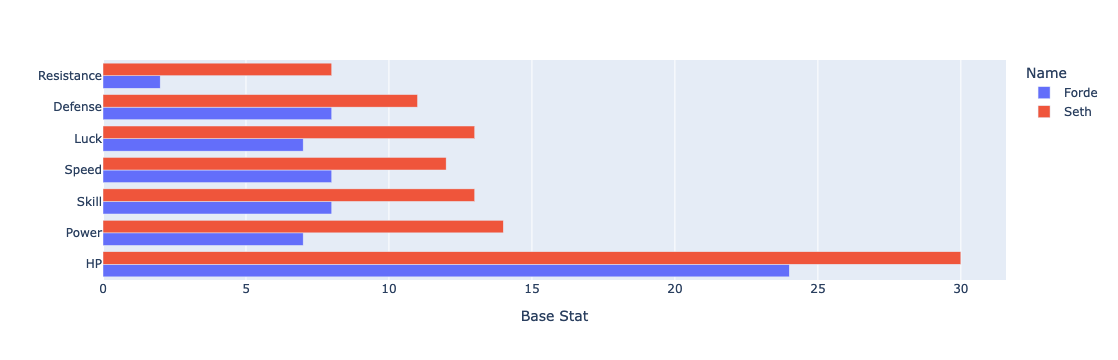

In [49]:
import plotly.express as px

table = con.sql(
    """
    SELECT *
    FROM baseswide
    WHERE name in ('Forde', 'Seth')
    """
)

table.show()
df = table.pl()
# Pivot to long format
df = df.melt(id_vars=["Name", "CampaignID"])

fig = px.bar(
    df, y="variable", x="value", color="Name", barmode="group",
    labels={"value": "Base Stat", "variable": ""}
)
fig.show()